### Homework 2

In [17]:
# Import relevant packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import statsmodels.api as sm

In [8]:
df = pd.read_excel(r'/Users/benshi/Downloads/default_data.xls').drop([0])
df = df.iloc[:,1:]

# Specify target and covariate data
# Using the most relevant X predictors calculated in HW 1, since it took WAY too long to run SVM on the full 
# dataset
X = df[['X6', 'X7', 'X8', 'X9', 'X10']]
y = df['Y']

# Replace missing with column mean
X = X.fillna(X.mean()) 

# Clip the data at 2% tails
X = X.clip(lower=X.quantile(0.02), upper=X.quantile(0.98), axis=1)

# Normalizing scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Converting to float:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)


(a) (SVM). This part of the question asks you to use the SVM approach to predict default. For all performance evaluation, you should start by leaving out 20% of your data for testing, and report the out-of-sample metrics (e.g. ROC AUC):
(i) Fit the SVM using linear, Gaussian (RBF in sklearn) and polynomial kernals. Compare the ROC AUC for the training data and the ROC AUC area for the cross validation (test) data. Provide some intuition for your results, especially on how different kernals perform differently. (HINT: For this step, you should change γ and C while fixing the kernel to be ‘linear’, ‘rbf’, and ‘poly’ each time. The idea is that you’re finding the “best” linear (poly, rbf) SVM.)

In [4]:
param_grid_lin = dict(C=[1, 10],
                  gamma = [0.001, 0.01, 0.1],
                  kernel=['linear'],
                  max_iter=[1e8],
                  class_weight=['balanced'])
param_grid_poly = dict(C=[1, 10],
                  gamma = [0.001, 0.01, 0.1],
                  kernel=['poly'],
                  max_iter=[1e8],
                  class_weight=['balanced'])
param_grid_rbf = dict(C=[1, 10],
                  gamma = [0.001, 0.01, 0.1],
                  kernel=['rbf'],
                  max_iter=[1e8],
                  class_weight=['balanced'])

# Define classifier
clf_svm = SVC()
# Scoring criterion
roc = make_scorer(roc_auc_score)

# Searching for best with grid search
grid_lin = GridSearchCV(estimator=clf_svm,
                    param_grid=param_grid_lin,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)
grid_poly = GridSearchCV(estimator=clf_svm,
                    param_grid=param_grid_poly,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)
grid_rbf = GridSearchCV(estimator=clf_svm,
                    param_grid=param_grid_rbf,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)

grid_result_svm_lin = grid_lin.fit(X_train, y_train)
grid_result_svm_poly = grid_poly.fit(X_train, y_train)
grid_result_svm_rbf = grid_rbf.fit(X_train, y_train)

# Printing them all out
print('Best Score for linear kernel:  ', grid_result_svm_lin.best_score_)
print('Best Params for linear kernel: ', grid_result_svm_lin.best_params_)
print('Best Score for polynomial kernel:  ', grid_result_svm_poly.best_score_)
print('Best Params for polynomial kernel: ', grid_result_svm_poly.best_params_)
print('Best Score for rbf kernel:  ', grid_result_svm_rbf.best_score_)
print('Best Params for rbf kernel: ', grid_result_svm_rbf.best_params_)

# Fitting on test data 
clf_svm_lin = SVC(**grid_result_svm_lin.best_params_).fit(X_train, y_train)
clf_svm_poly = SVC(**grid_result_svm_poly.best_params_).fit(X_train, y_train)
clf_svm_rbf = SVC(**grid_result_svm_rbf.best_params_).fit(X_train, y_train)

y_test_score_lin = clf_svm_lin.decision_function(X_test)
y_test_score_poly = clf_svm_poly.decision_function(X_test)
y_test_score_rbf = clf_svm_rbf.decision_function(X_test)

fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, y_test_score_lin)
fpr_svm_poly, tpr_svm_poly, _ = roc_curve(y_test, y_test_score_poly)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, y_test_score_rbf)

auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_poly = auc(fpr_svm_poly, tpr_svm_poly)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

print('ROC AUC area for test data, linear kernel: {:.3f}'.format(auc_svm_lin))
print('ROC AUC area for test data, polynomial kernel: {:.3f}'.format(auc_svm_poly))
print('ROC AUC area for test data, rbf kernel: {:.3f}'.format(auc_svm_rbf))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score for linear kernel:   0.686750344194014
Best Params for linear kernel:  {'C': 1, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear', 'max_iter': 100000000.0}
Best Score for polynomial kernel:   0.7026371552833273
Best Params for polynomial kernel:  {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'poly', 'max_iter': 100000000.0}
Best Score for rbf kernel:   0.7058645200368978
Best Params for rbf kernel:  {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 100000000.0}
ROC AUC area for test data, linear kernel: 0.701
ROC AUC area for test data, polynomial kernel: 0.707
ROC AUC area for test data, rbf kernel: 0.725


Looking at the results here, it seems that the rbf kernel performed best, with an ROC AUC area of 0.725 for test data. This makes relative sense, since the rbf kernel forms circular decision boundaries around data, so this would logically make it optimal for classification problems involving data that separate into well defined clusters. The linear kernel performed the worse, which makes sense, since it partitions space with a hyperplane, which is the most "undynamic" type of decision boundary. The polynomial performs in the middle: which is somewhat expected while unexpected, since it could potentially outperform the rbf in certain data sets. 

(ii) Based on the results from the previous step, try to optimize the classification perfor- mance of the SVM by choosing whatever parameters you could choose, and provide some rationale for these choices. Report your “optimized” ROC AUC on the test data.

In [18]:
# Rationale for these choices of parameters: As I ran the grid search over and over again, it seemed that the gamma
# value converged to an optimal value of 0.1 (0.1 was chosen regardless of the other candidates), and the C value
# converged to an optimal value of 5, so then I narrowed the options down to the numbers closest to the converged values.
# Grid search then continued to say that 5 and 0.1 were optimal values, so it must be optimal.
param_grid = dict(C=[1, 4, 5, 6, 7],
                  kernel=['rbf'],
                  gamma = [0.05, 0.1, 0.15], 
                  max_iter=[1e8],
                  class_weight=['balanced'])

# Define classifier
clf_svm = SVC()
# Scoring criterion
roc = make_scorer(roc_auc_score)

# Searching for best with grid search
grid = GridSearchCV(estimator=clf_svm,
                    param_grid=param_grid,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)

grid_result_svm = grid.fit(X_train, y_train)

print('Best Score:  ', grid_result_svm.best_score_)
print('Best Params: ', grid_result_svm.best_params_)

# Fitting on test data 
clf_svm = SVC(**grid_result_svm.best_params_).fit(X_train, y_train)
y_test_score = clf_svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_score)
auc_svm = auc(fpr_svm, tpr_svm)
print('Optimzed ROC AUC area for test data: {:.3f}'.format(auc_svm))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Score:   0.7067827879962439
Best Params:  {'C': 5, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 100000000.0}
Optimzed ROC AUC area for test data: 0.706


(b) (Decision trees). For this part, you need to use a decision tree to predict default:
(i) Grow a collection of trees by varying the maximum tree depth and the pruning param- eter. Try the grid search done in precept to see what combination seems to work well. For each tree, report accuracy (you should be using sklearn.tree.DecisionTreeClassifier for now rather than the random forest). Provide some intuition for your results. (E.g. why some trees appear to work better.)


In [36]:
# Growing a collection of Trees (Doing 4 Trees for now)
clf_tree = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.00001).fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

clf_tree = DecisionTreeClassifier(max_depth=50, ccp_alpha=0.1).fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

clf_tree = DecisionTreeClassifier(max_depth=10, ccp_alpha=1).fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

clf_tree = DecisionTreeClassifier(max_depth=50, ccp_alpha=0.1).fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))


# Seeing what parameters actually work well with Grid Search
param_grid = dict(max_depth=[10, 20, 30],
                  ccp_alpha=[0.00001,0.0001, 0.001],
                    min_samples_leaf=[])

# Define classifier
clf_tree = DecisionTreeClassifier()
# Scoring criterion
roc = make_scorer(roc_auc_score)

# Searching for best with grid search
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)

grid_result_tree = grid.fit(X_train, y_train)

print('Best Score:  ', grid_result_tree.best_score_)
print('Best Params: ', grid_result_tree.best_params_)

clf_tree = DecisionTreeClassifier(**grid_result_tree.best_params_).fit(X_train, y_train)

# We are comparing y_test vs y_pred here
y_pred = clf_tree.predict(X_test)
print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))

Train accuracy is: 0.8224583333333333
Test accuracy is: 0.8191666666666667
Train accuracy is: 0.7792083333333333
Test accuracy is: 0.7771666666666667
Train accuracy is: 0.7792083333333333
Test accuracy is: 0.7771666666666667
Train accuracy is: 0.7792083333333333
Test accuracy is: 0.7771666666666667
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:   0.6620726732118593
Best Params:  {'ccp_alpha': 0.0001, 'max_depth': 5}
Train accuracy is: 0.8220833333333334
Test accuracy is: 0.8198333333333333


According to the results, the best parameters for the formation of the decisions trees was when ccp_alpha was 1e-4, and min_samples_leaf was 20. The ccp_alpha optimal value was relatively close-ish to zero: which means that a smaller portion of the tree was pruned, leading to a decision tree that generalizes a bit on the less side, which could be beneficial for the given distribution of the data. The most optimal max_depth seemed to be 5, which is on the less side: which could make sense given our data if it was in a more clustered distribution, therefore, it would be better not to make very deep decision trees with lots of splits, as it could lead to overfitting. As for the test trees we did, it seemed that the trees with low depth and low ccp did the best, which leads to a somewhat general split, which could be good for the distrubtion of our data set. 

(ii) Find the maximum tree depth and pruning parameter that maximise the recall instead. Provide some intuition for why we may want to consider recall in place of accuracy.

In [9]:
param_grid = dict(min_samples_leaf=[5, 10, 20],
                  ccp_alpha=[0,0.00001,0.0001])

# Define classifier
clf_tree = DecisionTreeClassifier()

# Searching for best with grid search
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring="recall",
                    verbose=1,
                    cv=5,
                    n_jobs=-1)

grid_result_tree = grid.fit(X_train, y_train)

print('Best Score:  ', grid_result_tree.best_score_)
print('Best Params: ', grid_result_tree.best_params_)

clf_tree = DecisionTreeClassifier(**grid_result_tree.best_params_).fit(X_train, y_train)

# We are comparing y_test vs y_pred here
y_pred = clf_tree.predict(X_test)
print('Train recall is: ' + str(recall_score(y_train, clf_tree.predict(X_train))))
print('Test recall is: ' + str(recall_score(y_test, y_pred)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score:   0.3793204696491885
Best Params:  {'ccp_alpha': 1e-05, 'min_samples_leaf': 20}
Train recall is: 0.382902434421589
Test recall is: 0.3679880329094989


We may want to consider recall instead of accuracy because sometimes we want to value each outcome equally instead of focusing on one type of outcome over another: where both false negatives and true positives must be equally regarded. In this situation, it would make more sense to use recall, since we really really want to find people who will default, even at the expense of classifying more people as willing to default. 

(iii) Explain the difference between a random forest and a decision tree.

Although both are types of trees, it uses different algorithms to generate the trees. 
A decision tree usually implements a more greedy heuristic to find the most optimal decision tree by making locally optimized decisions: it looks for the split at each node that minimizes the classification error rate (fraction of training observations in a given region that doesn't belong to the most common class).
A random tree is a more optimized algorithm offers the potential to make seemingly useless splits early on, but very useful splits later. It takes a random sample of m out of the total n predictors, and only uses those for splitting in a similar process to the decision tree process described above. (Forces tree to consider otherwise seemingly pointless predictors)

Using an aggregation technique (such as random forest or boosting), attempt to optimize the classification performance of your model. You may use any skills/tricks that you believe may help so long as the basic model remains a decision tree. Plot the ROC curve and calculate the area under the ROC curve for your “optimized” model.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score:   0.6622216654539967
Best Params:  {'learning_rate': 0.2, 'n_estimators': 1000}


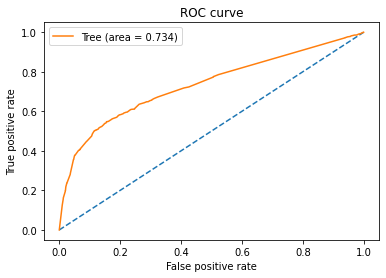

In [38]:
param_grid = dict(n_estimators=[500, 1000, 1500],
                  learning_rate=[0.05, 0.1, 0.2]
             )

# Define classifier
dtc = DecisionTreeClassifier()
clf_tree = AdaBoostClassifier(base_estimator = dtc)
# Scoring criterion
roc = make_scorer(roc_auc_score)

# Searching for best with grid search
grid = GridSearchCV(estimator=clf_tree,
                    param_grid=param_grid,
                    scoring=roc,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)

grid_result_tree = grid.fit(X_train, y_train)

print('Best Score:  ', grid_result_tree.best_score_)
print('Best Params: ', grid_result_tree.best_params_)

# Plot the ROC and compare
clf_tree = AdaBoostClassifier(**grid_result_tree.best_params_).fit(X_train, y_train)
y_pred_tree = clf_tree.predict_proba(X_test)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_tree[:,1])
auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(1)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr_tree, tpr_tree, label='Tree (area = {:.3f})'.format(auc_tree))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

(c) Compare the performance of the logistic regression (from homework 1), decision tree models (including single tree model, random forests, and other tree based models), and SVM in terms of accuracy/precision/recall and ROC. Briefly comment on the differences that you find.

In [29]:
# Obtaining the accuracy, recall and AUC ROC of the logistic regression: (precision is omitted due to low relevance)
clf_logit = LogisticRegression().fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_tree[:,1])
auc_logit = auc(fpr, tpr)
print(auc_logit)

print('Train accuracy is: ' + str(accuracy_score(y_train, clf_tree.predict(X_train))))
print('Test accuracy is: ' + str(accuracy_score(y_test, y_pred)))
print('Train recall is: ' + str(recall_score(y_train, clf_tree.predict(X_train))))
print('Test recall is: ' + str(recall_score(y_test, y_pred)))

0.7334143244186999
Train accuracy is: 0.8209583333333333
Test accuracy is: 0.82
Train recall is: 0.36270994527269296
Test recall is: 0.3537771129394166


In comparison to the logistic regression model on this data set, The train and test accuracy of the single tree model, SVM, and the boosted model all performed relatively similarly. I believe the reason for this is because I omitted alot of the data due to run time issues, and only focused on the 5 most important variables. Since the 5 most correlated variables happened to all be the history of past payment and are all similar to each other, this means that no matter how the variety of classification methods tried to optimize, the lack of variation in the predictor variables made it difficult to optimize past a threshold point, which can be seen as most of the optimized values of AUC ROC, accuracy, and even recall converge to around the same value. 